In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lib_eval as eval
import pickle as pk
import pandas as pd
import numpy as np
from numpy import *
import time
import matplotlib.pyplot as plt
from tqdm import *
from pylab import *
from multiprocessing import Pool
import pickle
from datetime import datetime
import os
import statsmodels.api as sm
import julian
import torch
import matplotlib.pyplot as plt
from itertools import permutations
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from scipy.signal import medfilt
import copy
from scipy.stats import multivariate_normal as mn
nasa_julian = 98
cnes_julian = 90
import os
os.environ['PROJ_LIB']= "C:\\Users\\vankh\\Anaconda3\\Lib\\site-packages\\mpl_toolkits\\basemap"
from mpl_toolkits.basemap import Basemap

## III. Work on a large dataset extracted to the presure = 1000 in the GulfStream

In [3]:
# Load coordinates, dates
coords_g_train =  pd.read_pickle('data/GS-p_1000/feature_train_GS_1000.pkl')
x_g_train = pd.read_pickle('data/GS-p_1000/x_train_GS_1000.pkl')
lat_train, lon_train, juld_train = coords_g_train[:,0],coords_g_train[:,1],coords_g_train[:,2]
pres_train = x_g_train[:,-1]
coords_g_test =  pd.read_pickle('data/GS-p_1000/feature_test_GS_1000.pkl')
x_g_test = pd.read_pickle('data/GS-p_1000/x_test_GS_1000.pkl')
lat_test, lon_test, juld_test = coords_g_test[:,0],coords_g_test[:,1],coords_g_test[:,2]
pres_test = coords_g_test[:,-1]
map = Basemap(projection='merc',llcrnrlat=30,urcrnrlat=50,llcrnrlon=-75,urcrnrlon=-36,resolution='c')

In [4]:
# Ground truth salinity
gt_sal_train = pd.read_pickle('data/GS-p_1000/y_train_GS_1000.pkl')[:,1]

In [5]:
# Estimated temperature
est_sal_train = np.loadtxt('trained-model/GS-p_1000/y_h_train_E9_8.txt')

In [6]:
# Residual plot of temperature
residual_sal_train = est_sal_train-gt_sal_train

In [7]:
# Ground truth temperature
gt_temp_train = pd.read_pickle('data/GS-p_1000/y_train_GS_1000.pkl')[:,0]
gt_temp_test = pd.read_pickle('data/GS-p_1000/y_test_GS_1000.pkl')[:,0]

In [8]:
# Estimated temperature
est_temp_train = np.loadtxt('trained-model/GS-p_1000/y_h_train_E8_8.txt')
est_temp_test = np.loadtxt('trained-model/GS-p_1000/y_h_test_E8_8.txt')

In [9]:
# Residual plot of temperature
residual_temp_train = est_temp_train-gt_temp_train
residual_temp_test = est_temp_test-gt_temp_test

## 1. Spatial temperature and salinity representation at diffrent levels of depth

#### A slice of the temperature distribution at the pressure's value =  700. 

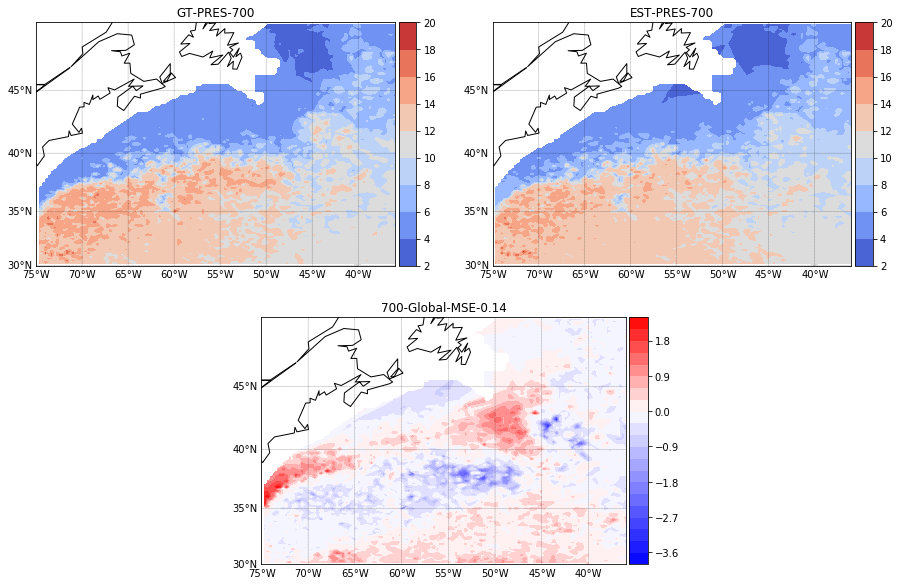

In [78]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_temp_train, est_temp_train, residual_temp_train, 700, 4, "700", cmap_temp = True)

#### A slice of the temperature distribution at the longitude's value =  -55. 

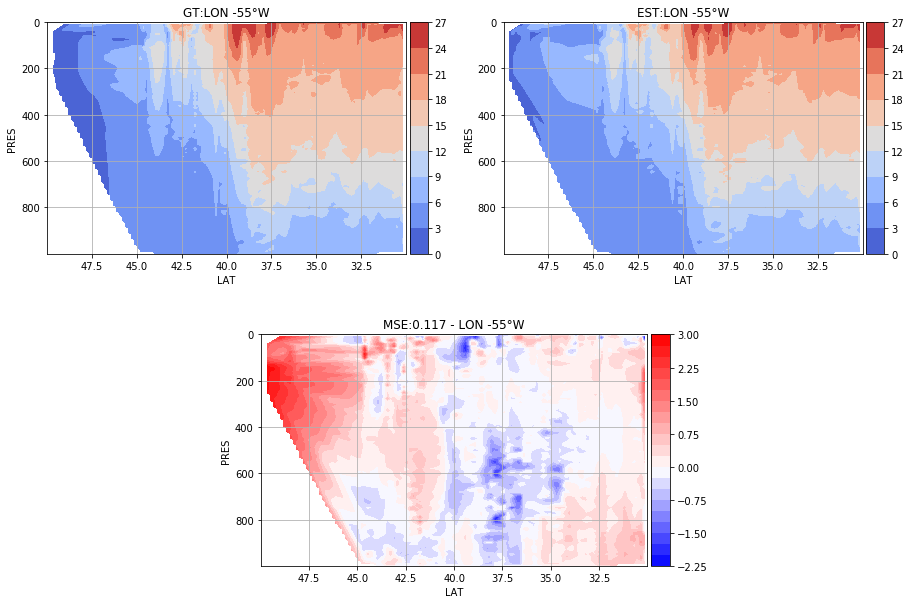

In [84]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_temp_train, est_temp_train, residual_temp_train, -55,  4, "-55LON", cmap_temp = True, surf = 1)

#### A slice of the temperature distribution at the latitude's value =  40. 

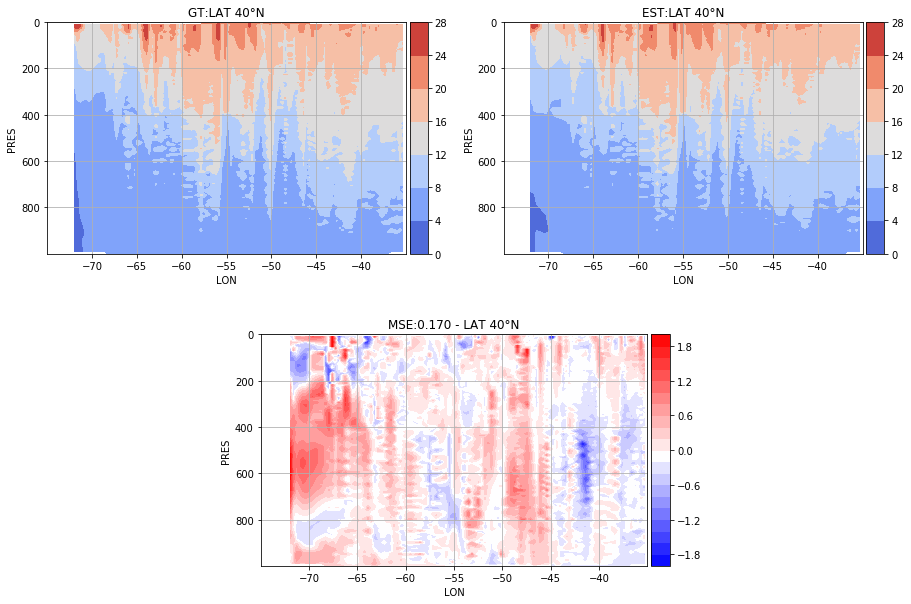

In [85]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_temp_train, est_temp_train, residual_temp_train, 40, 4, "40LAT", cmap_temp = True, surf = 2)

#### A slice of the salinity distribution at the pressure's value =  700. 

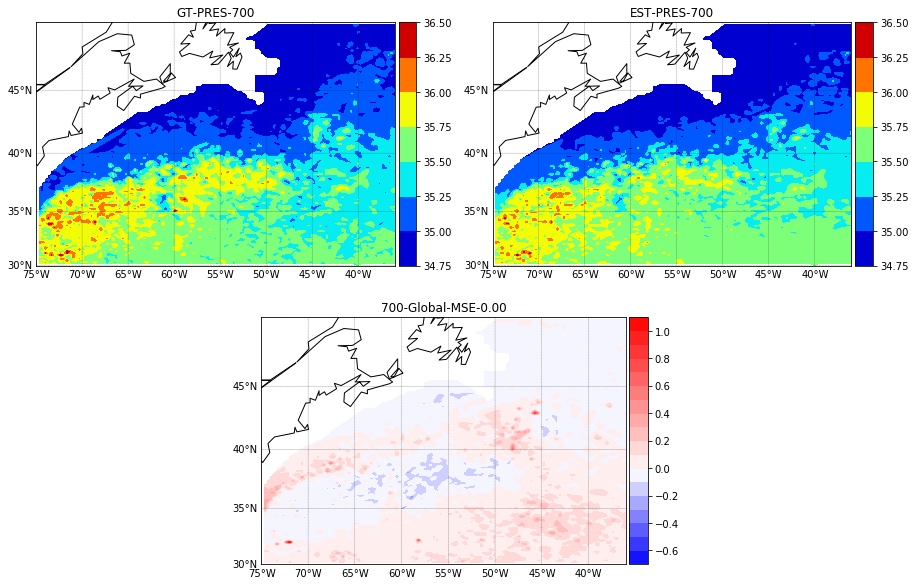

In [86]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_sal_train, est_sal_train, residual_sal_train, 700, 4, "700SAL", cmap_temp = False)

#### A slice of the temperature distribution at the pressure's value =  20. (surface) 

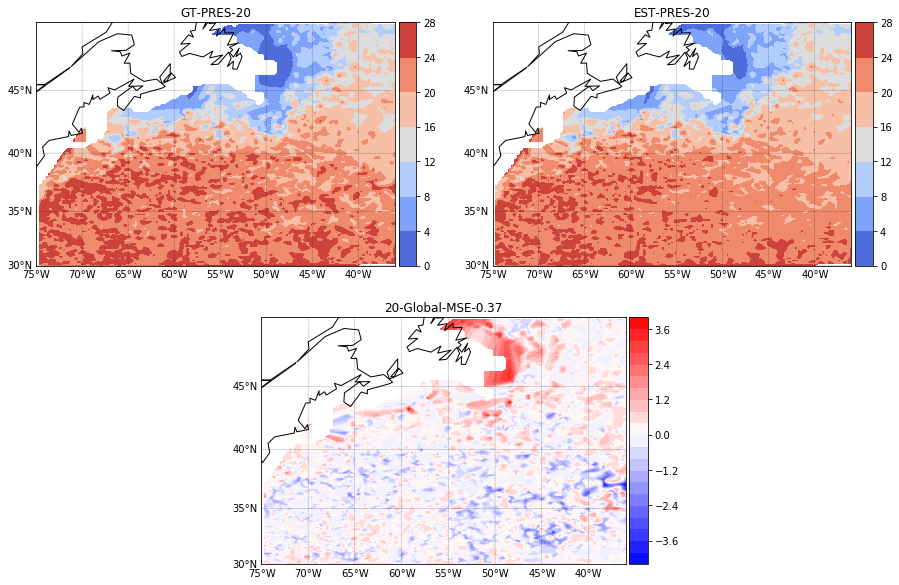

In [87]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_temp_train, est_temp_train, residual_temp_train,20, 4, "20TEMP", cmap_temp = True)

#### A slice of the salinity distribution at the pressure's value =  20. (surface)

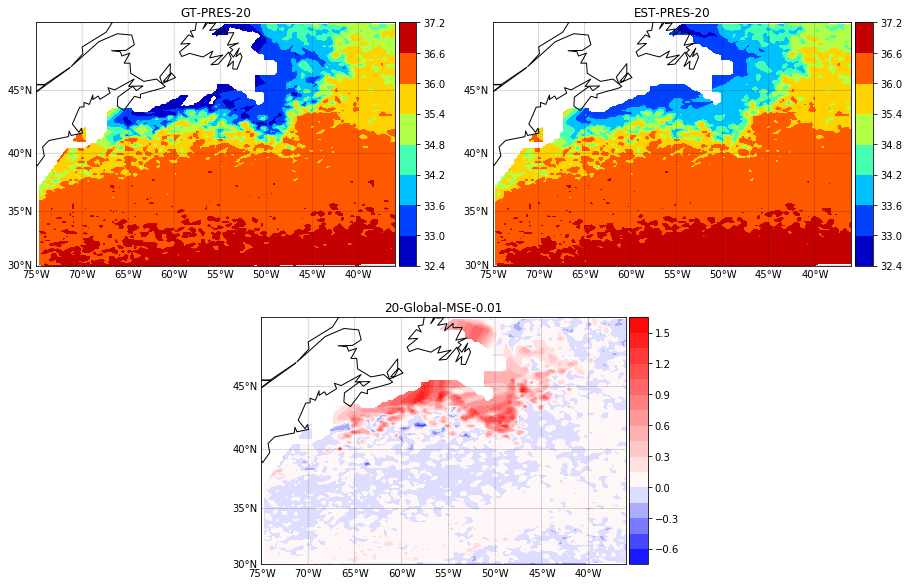

In [88]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_sal_train, est_sal_train, residual_sal_train, 20,  4, "20SAL", cmap_temp = False)

#### A slice of the salinity distribution at the longitude's value =  -55. 

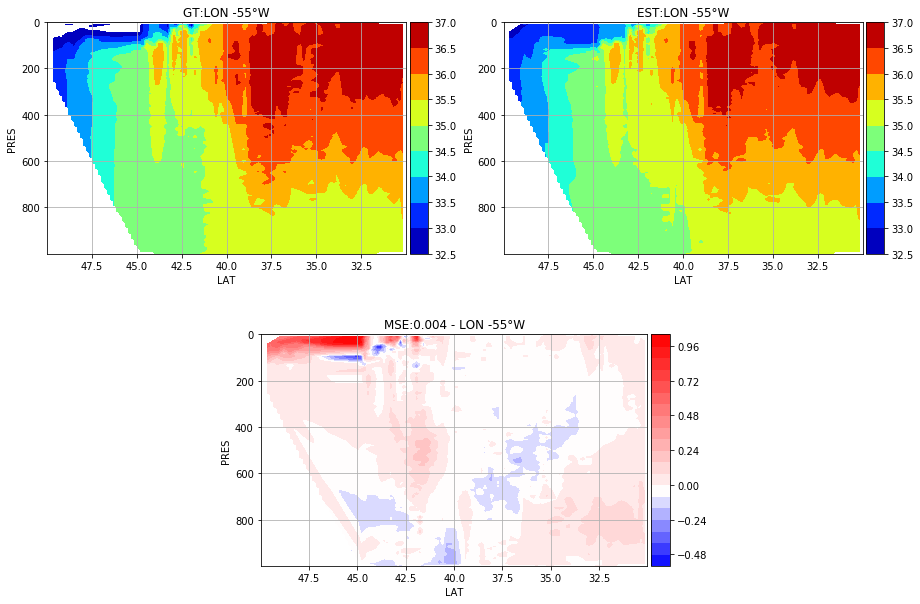

In [100]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_sal_train, est_sal_train, residual_sal_train, -55,  4, "-55LON_sal", cmap_temp = False, surf = 1)

#### A slice of the salinity distribution at the latitude's value =  40. 

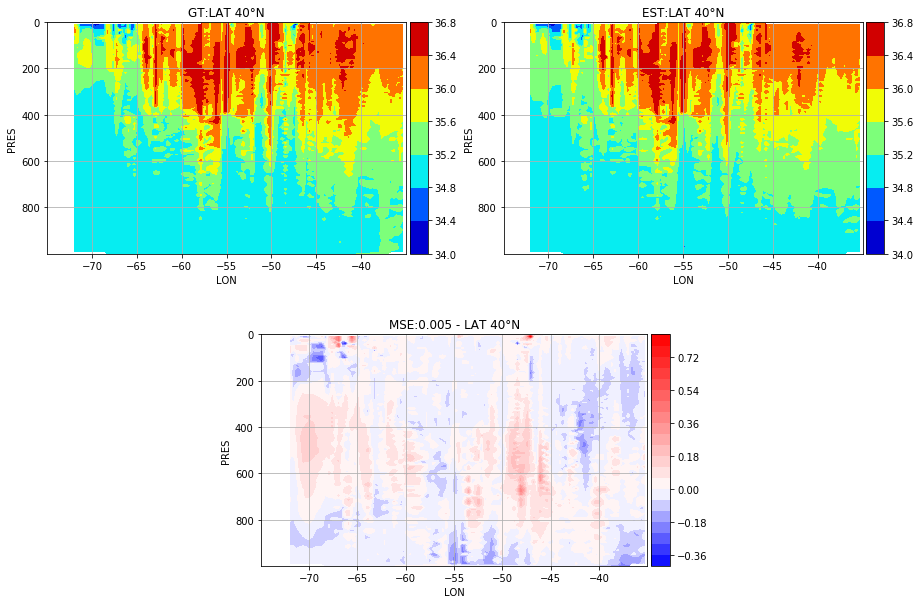

In [102]:
eval.target_predict(lon_train, lat_train, pres_train, 120, 120, map, gt_sal_train, est_sal_train, residual_sal_train, 40,  4, "40LAT_sal", cmap_temp = False, surf = 2)

### Seasonal temperature visualization  at severals small local regions

In [10]:
# Following the temperature evolution
X = pd.read_pickle("data/Gs-p_1000/x_train_GS_1000.pkl")
profiles = pd.read_pickle('data/Gs-p_1000/feature_train_GS_1000.pkl')[:,-1]

E8_info = pd.read_pickle("trained-model/Gs-p_1000/E8_info.pkl")
E8_f_x = E8_info["feature_mean"]
E8_std_x = E8_info["feature_std"]
E8_beta = pd.read_pickle("trained-model/Gs-p_1000/beta_E8_8.pkl")
E8_lambda_ = pd.read_pickle("trained-model/Gs-p_1000/lambda_E8_8.pkl")
E8_sigma = pd.read_pickle("trained-model/Gs-p_1000/sigma_E8_8.pkl")

In [11]:
E9_info = pd.read_pickle("trained-model/Gs-p_1000/E9_info.pkl")
E9_f_x = E9_info["feature_mean"]
E9_std_x = E9_info["feature_std"]
E9_beta = pd.read_pickle("trained-model/Gs-p_1000/beta_E9_8.pkl")
E9_lambda_ = pd.read_pickle("trained-model/Gs-p_1000/lambda_E9_8.pkl")
E9_sigma = pd.read_pickle("trained-model/Gs-p_1000/sigma_E9_8.pkl")

In [12]:
#### Dominant mode for each profile on the maps
pi_hat_train_temp = np.loadtxt('trained-model/GS-p_1000/pi_h_train_E8_8.txt')

In [13]:
#### Dominant mode for each profile on the maps
pi_hat_train_sal = np.loadtxt('trained-model/GS-p_1000/pi_h_train_E9_8.txt')

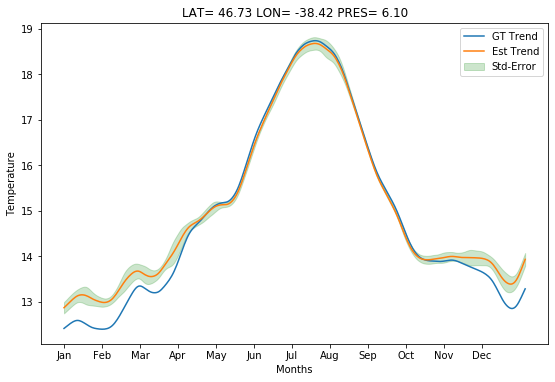

In [98]:
p_index = 112491
fig = figure(figsize = (20,13))
eval.sea_temp_plot(p_index,coords_g_train,X, gt_temp_train, est_temp_train, fig, t1 = 1000,t2 = 1000, t3 =50, savename = "seas_temp", lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 221, temp = True)

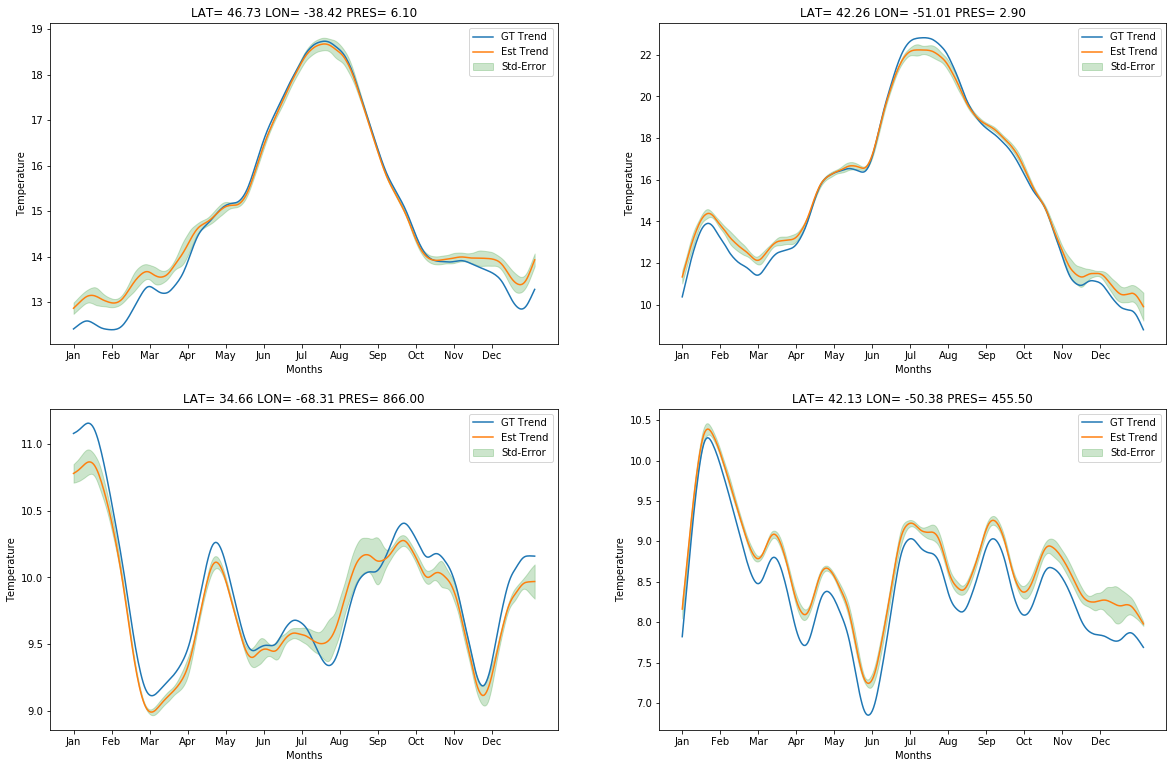

In [22]:
p_index = 112491
figure(figsize = (20,13))
eval.sea_temp_plot(p_index,coords_g_train,X, gt_temp_train, est_temp_train,t1 = 1000,t2 = 1000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 221, temp = True)
p_index = 399
eval.sea_temp_plot(p_index,coords_g_train,X, gt_temp_train, est_temp_train,t1 = 1000,t2 = 1000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 222, temp = True)
p_index = 18
eval.sea_temp_plot(p_index,coords_g_train,X, gt_temp_train, est_temp_train,t1 = 2000,t2 = 2000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 223, temp = True)
p_index = 35980
eval.sea_temp_plot(p_index,coords_g_train,X, gt_temp_train, est_temp_train,t1 = 2000,t2 = 2000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 224, temp = True)

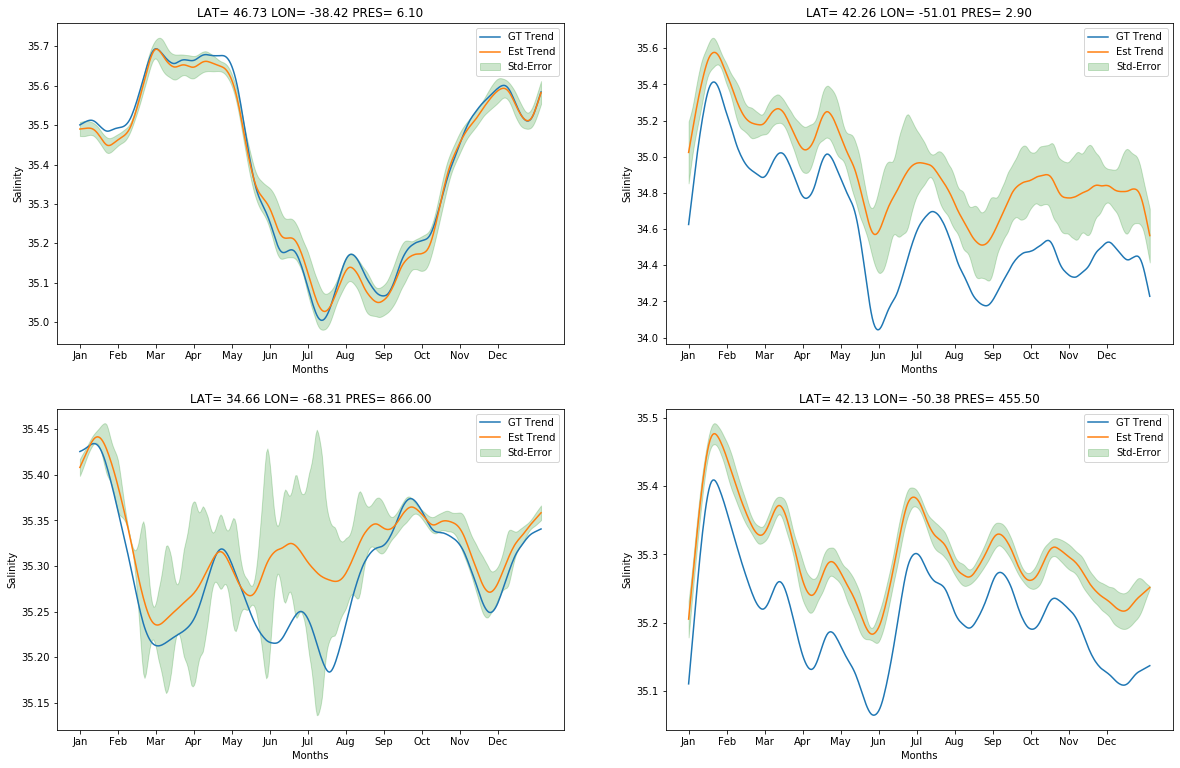

In [172]:
p_index = 112491
figure(figsize = (20,13))
eval.sea_temp_plot(p_index,coords_g_train,X, gt_sal_train, est_sal_train,t1 = 1000,t2 = 1000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 221, temp = False)
p_index = 399
eval.sea_temp_plot(p_index,coords_g_train,X, gt_sal_train, est_sal_train,t1 = 1000,t2 = 1000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 222, temp = False)
p_index = 18
eval.sea_temp_plot(p_index,coords_g_train,X, gt_sal_train, est_sal_train,t1 = 2000,t2 = 2000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 223,  temp = False)
p_index = 35980
eval.sea_temp_plot(p_index,coords_g_train,X, gt_sal_train, est_sal_train,t1 = 2000,t2 = 2000, t3 =50, lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 224,  temp = False)

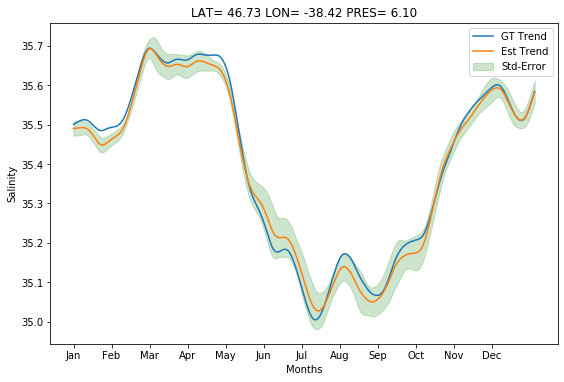

In [99]:
p_index = 112491
fig = figure(figsize = (20,13))
eval.sea_temp_plot(p_index,coords_g_train,X, gt_sal_train, est_sal_train, fig, t1 = 1000,t2 = 1000, t3 =50, savename = "seas_sal1", lat_thres = 3,lon_thres = 3, date_thres = 4745, depth_thres = 10, combine = True ,subplot = 221, temp = False)

### Spatial dynamical mode representation at different  depth levels

pres = 250

-0.00019179999995344588


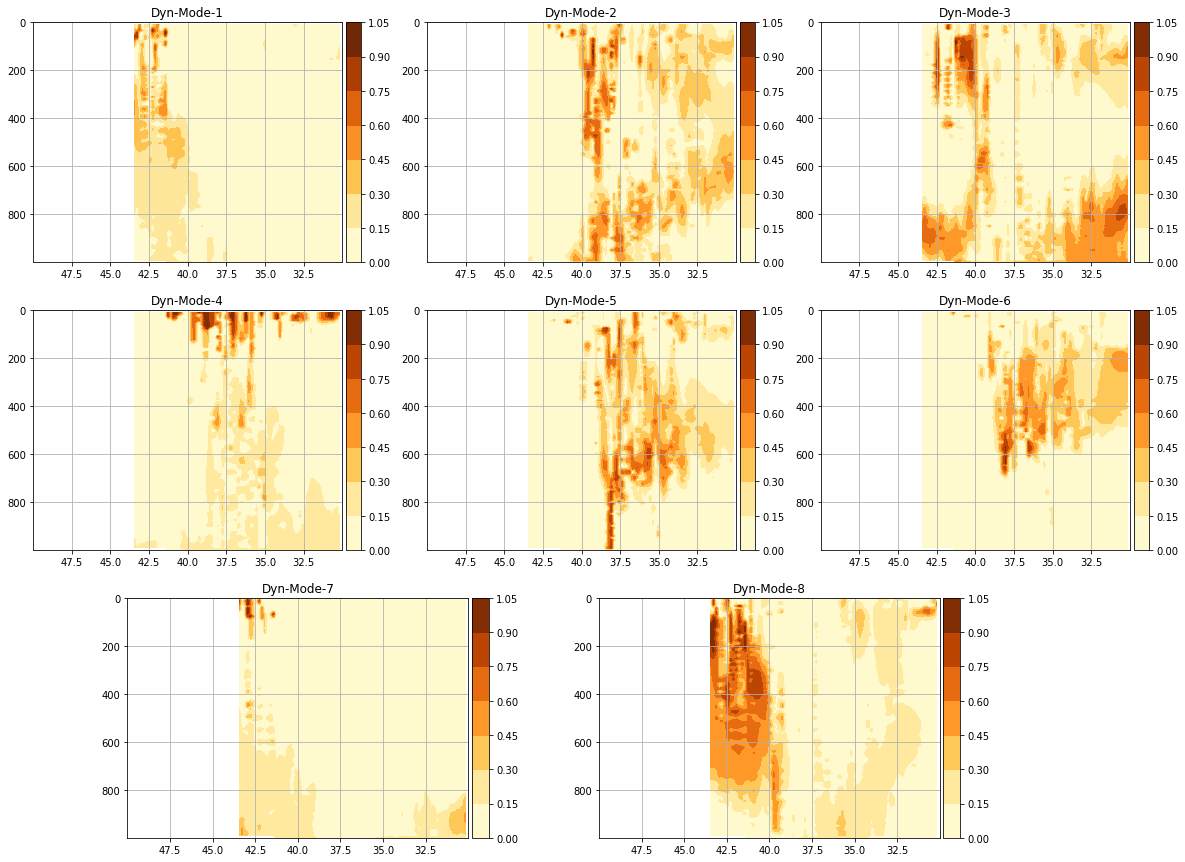

In [14]:
eval.spa_dyna_mode_dis(pi_hat_train_temp, lon_train, lat_train, pres_train, 120, 120, -60, 3, map, True, surf = 1)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.46s/it]


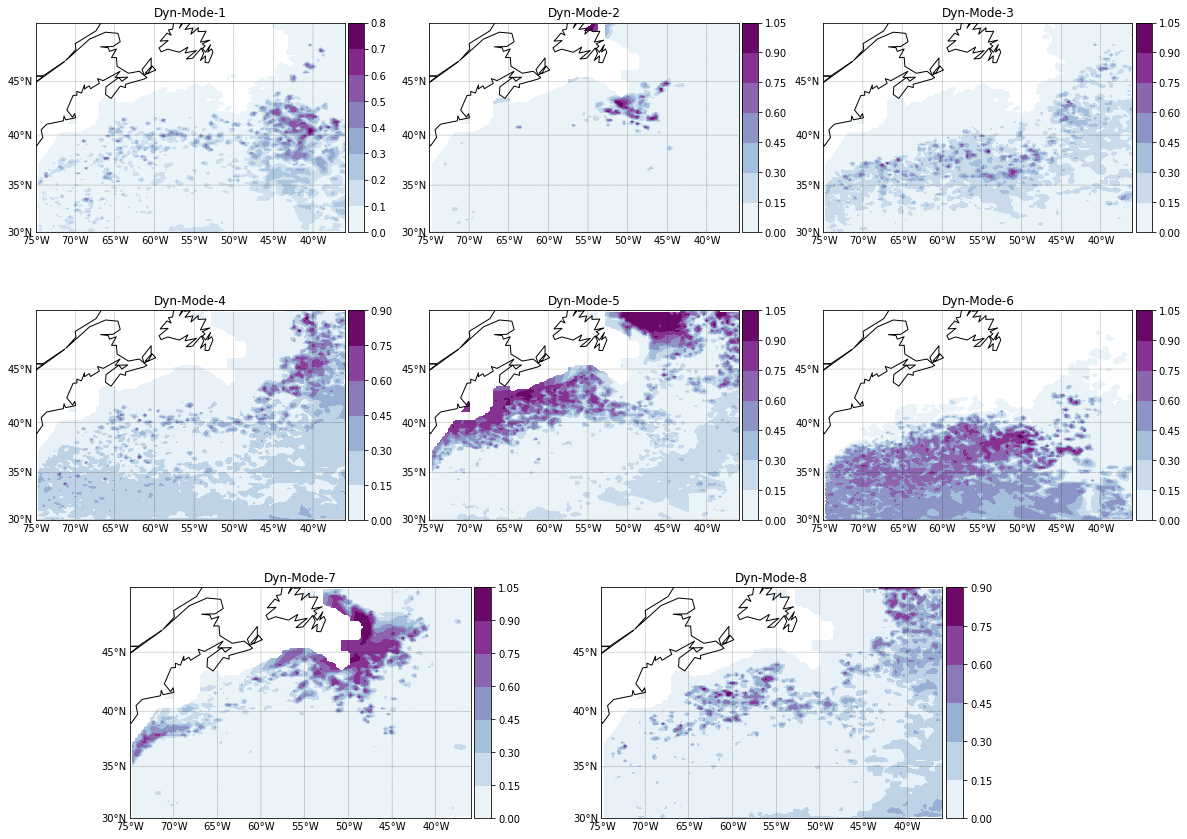

In [173]:
eval.spa_dyna_mode_dis(pi_hat_train_sal, lon_train, lat_train, 120, 120, pres_train, 200 , 300, 250, 3, map, temp = False)

pres = 450

-9.299999999257125e-05


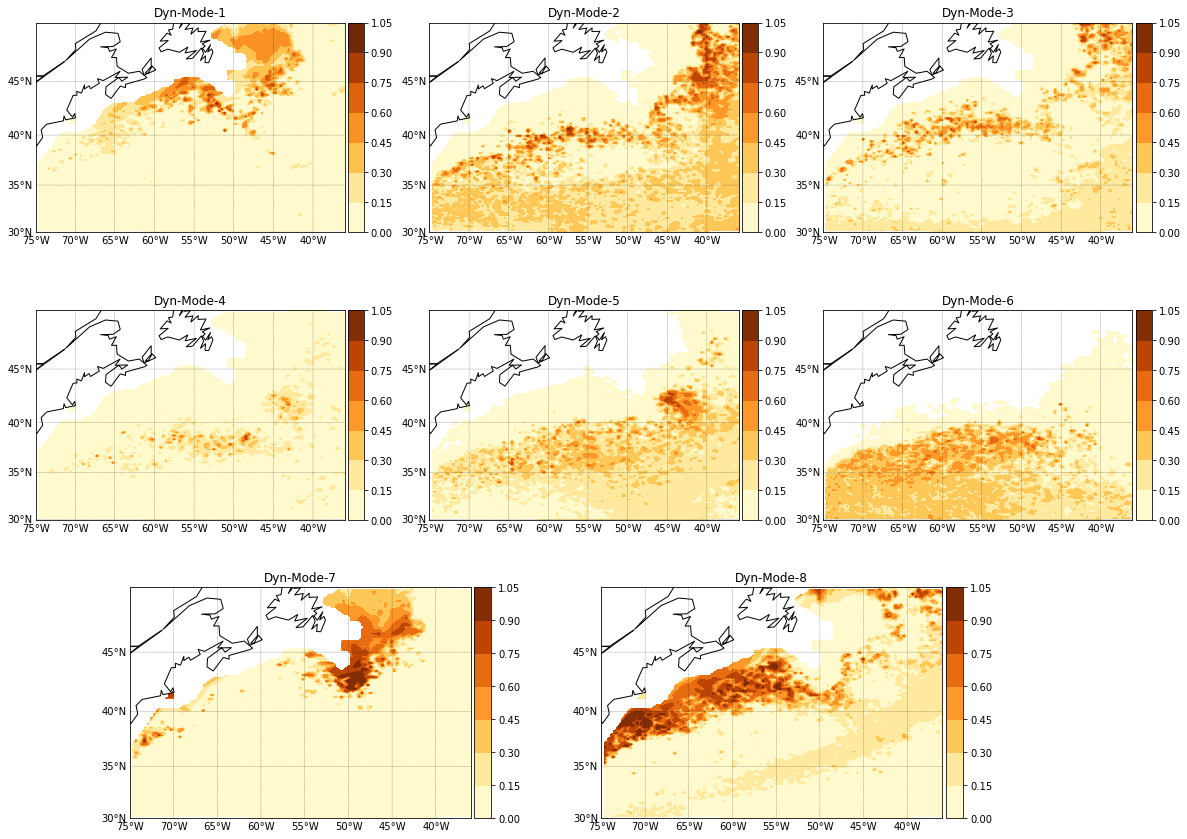

In [15]:
eval.spa_dyna_mode_dis(pi_hat_train_temp, lon_train, lat_train, pres_train, 120, 120, 300, 3, map, True, surf = 0)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.50s/it]


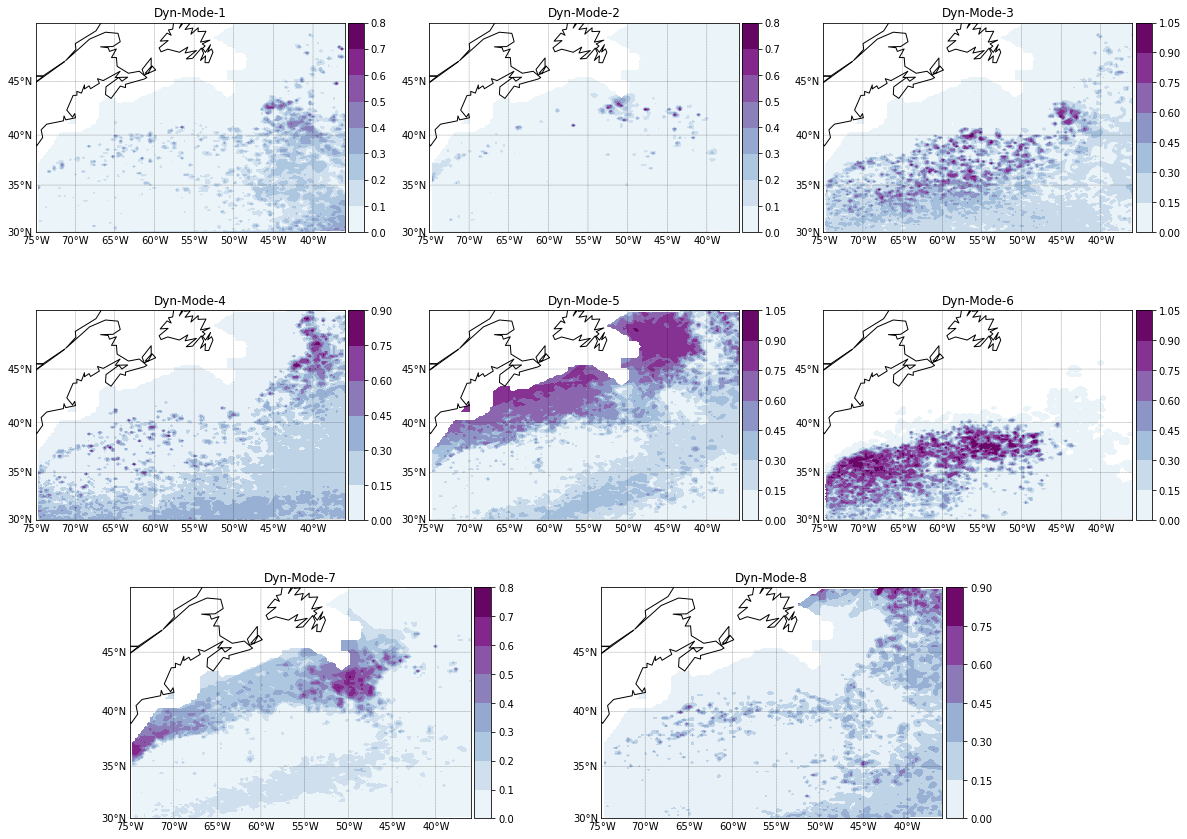

In [174]:
eval.spa_dyna_mode_dis(pi_hat_train_sal, lon_train, lat_train, 120, 120, pres_train, 400 , 500, 450, 3, map, temp = False)

### Temporal dynamical mode representation at different  region in the ocean (medium region)

Number of data points N= 251107


100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:01<00:00, 296.97it/s]


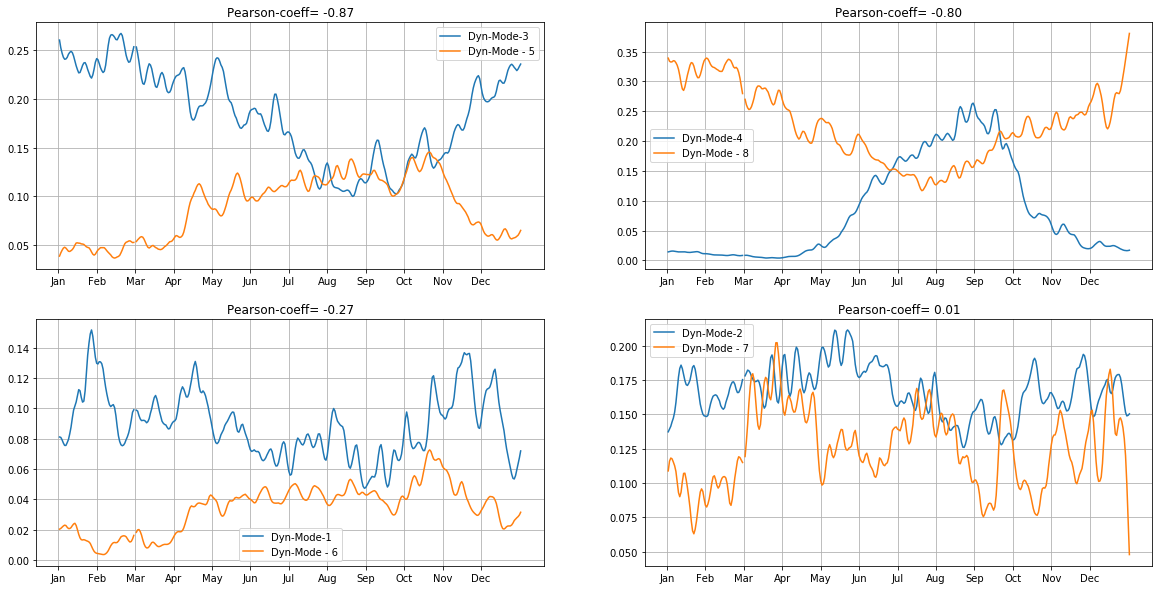

In [302]:
eval.temp_dyna_mode_var(pi_hat_train_temp, lon_train, lat_train, juld_train,  pres_train, sel_lat = 45, sel_lon = -43, sel_pres = 50, lon_thres = 10, lat_thres = 10, pres_thres = 100, thres = 20)

Number of data points N= 251107


100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:01<00:00, 300.30it/s]


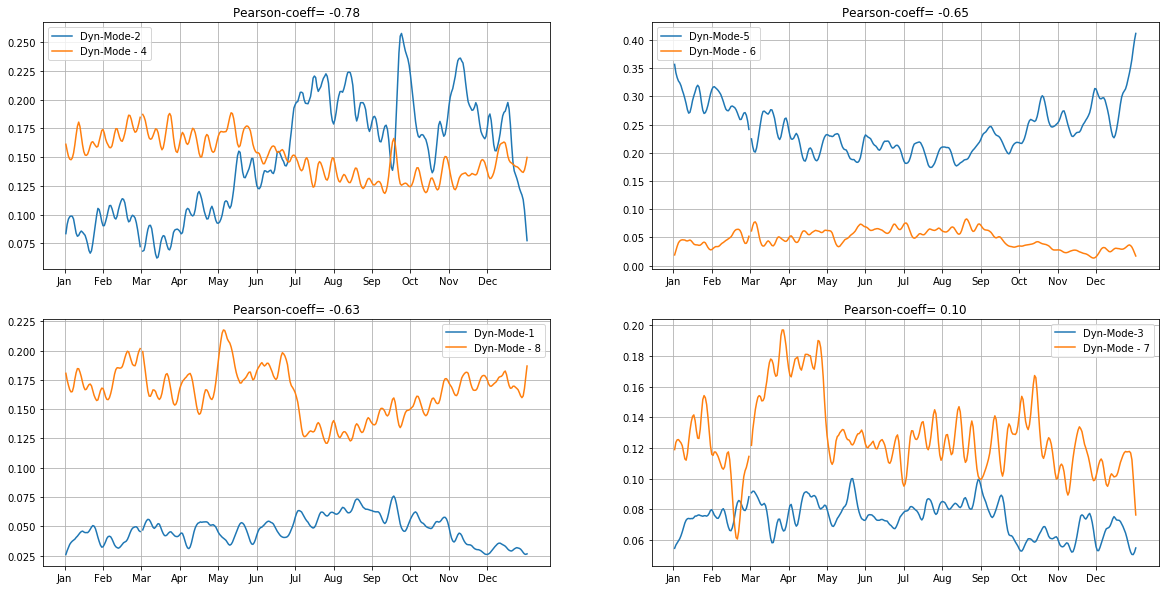

In [175]:
eval.temp_dyna_mode_var(pi_hat_train_sal, lon_train, lat_train, juld_train,  pres_train, sel_lat = 45, sel_lon = -43, sel_pres = 50, lon_thres = 10, lat_thres = 10, pres_thres = 100, thres = 20)

Number of data points N= 307412


100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:01<00:00, 242.79it/s]


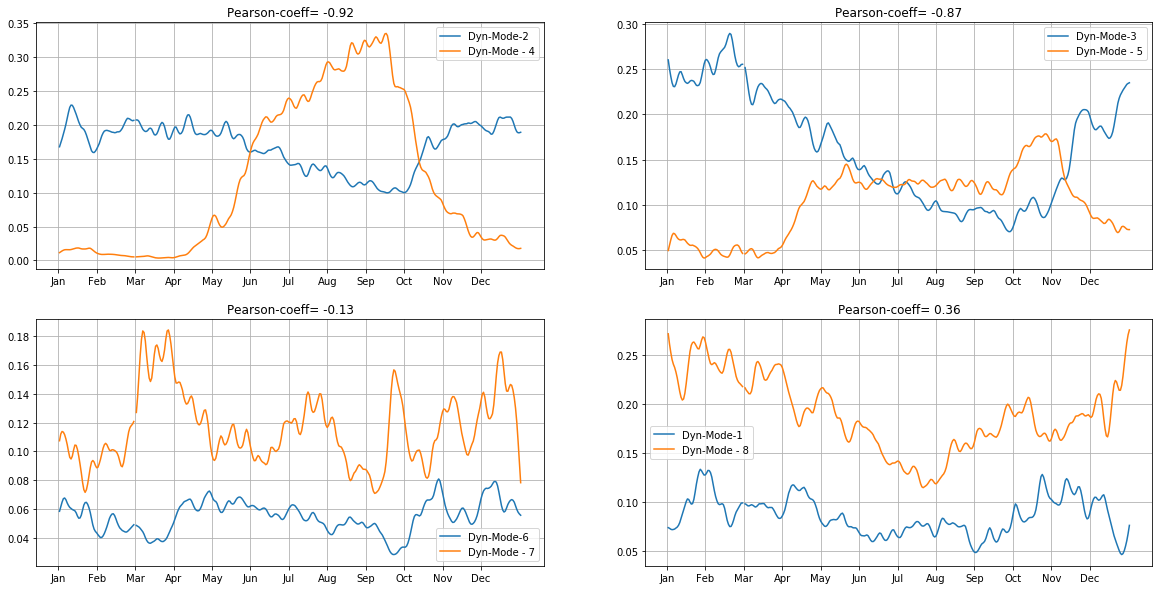

In [301]:
eval.temp_dyna_mode_var(pi_hat_train_temp, lon_train, lat_train, juld_train,  pres_train, sel_lat = 43, sel_lon = -50, sel_pres = 50, lon_thres = 10, lat_thres = 10, pres_thres = 100, thres = 30)

Number of data points N= 307412


100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:01<00:00, 245.97it/s]


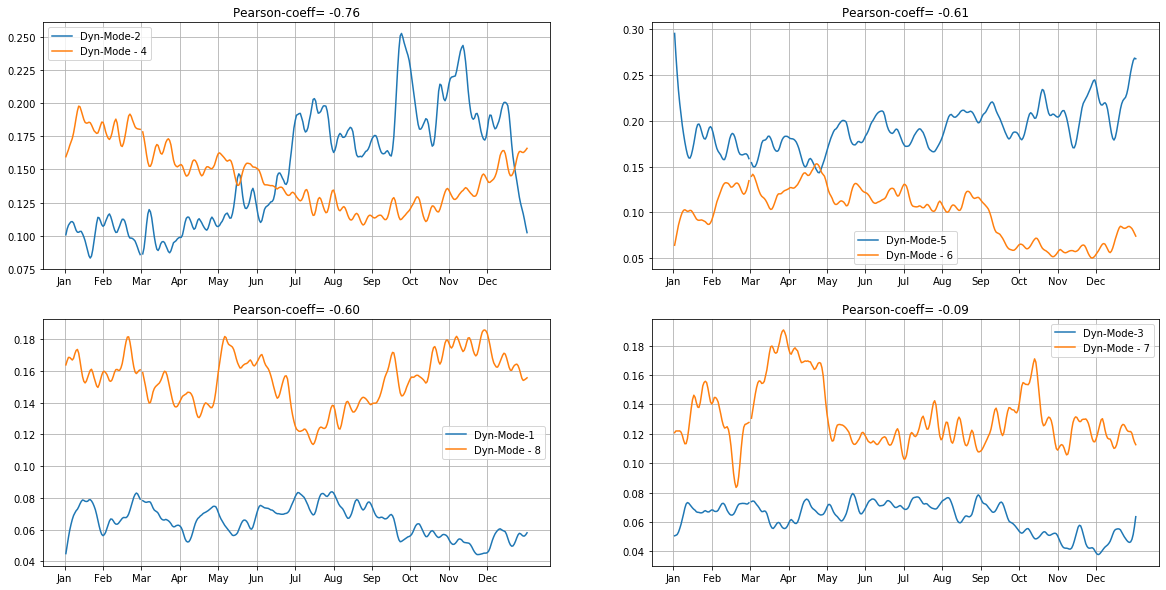

In [176]:
eval.temp_dyna_mode_var(pi_hat_train_sal, lon_train, lat_train, juld_train,  pres_train, sel_lat = 43, sel_lon = -50, sel_pres = 50, lon_thres = 10, lat_thres = 10, pres_thres = 100, thres = 30)

### Turbulence observations

Number of data:  76271


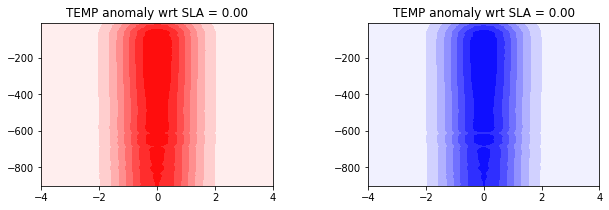

In [46]:
fig = plt.figure(figsize = (10,3))
subplots_adjust(wspace=0.2, hspace=0.2)
eval.turbulence(pi_hat_train_temp, E8_beta, E8_f_x, E8_std_x, lon_train, lat_train, juld_train, X, title = "TEMP anomaly wrt SLA = 0.00")

Number of data:  76271


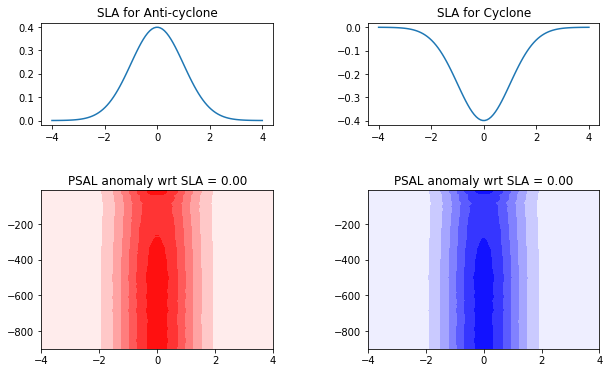

In [47]:
fig = plt.figure(figsize = (10,6))
subplots_adjust(wspace=0.2, hspace=0.2)
eval.turbulence(pi_hat_train_sal, E9_beta, E9_f_x, E9_std_x, lon_train, lat_train, juld_train, X, title = "PSAL anomaly wrt SLA = 0.00")

https://www.elsevier.com/connect/11-steps-to-structuring-a-science-paper-editors-will-take-seriously

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3474301/